**RUN the setup section before running any other section**

## Setup, Data Processing and Exploration

The labels to predict are : 

* p(mbar)
* T (degC)
* rh (%)
* wv (m/s)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def custom_date_parser(date_string):
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

data = pd.read_csv(os.path.join(path, "weather_train.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
data.head()

data.sort_values(by='Date Time', ascending=True, inplace=True)

<ipython-input-116-577746d19954>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


Let's rename the labels so that they are more convenient to use.

In [ ]:
data = data.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

With some prior exploration, we saw that not all time stamps were from a round hour, this could have caused non consecutive hours, eventhough the time stamps belonged to the same hour. In order to cope with that, we set the minute to always be "00".

In [ ]:
data['date'] = data['date'].apply(lambda x: x.replace(minute=0))

Let's check if there are non consecutive dates in the dataset

In [ ]:
# create an empty list to store the indices of non-consecutive rows
non_consecutive_rows = []

# iterate through the rows of the dataframe
for i in range(1, len(data)):
    # get the current and previous timestamps
    curr_timestamp = data['date'][i]
    prev_timestamp = data['date'][i-1]
    
    # check if the difference between the timestamps is greater than one hour
    if (curr_timestamp - prev_timestamp) > pd.Timedelta(hours=1):
        # if so, append the index of the current row to the list of non-consecutive rows
        non_consecutive_rows.append(i)

# display the list of non-consecutive rows
print(f"Number of non consecutive rows {len(non_consecutive_rows)}")
print(f"Percentage of non consecutive rows : {len(non_consecutive_rows) / len(data['date']) * 100:.1f}%")

Number of non consecutive rows 1
Percentage of non consecutive rows : 0.0%


Virtually, we only have consecutive dates.

In [ ]:
data.info()
data.head()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             56072 non-null  datetime64[ns]
 1   p                56072 non-null  float64       
 2   T                56072 non-null  float64       
 3   Tpot (K)         56072 non-null  float64       
 4   Tdew (degC)      56072 non-null  float64       
 5   rh               56072 non-null  float64       
 6   VPmax (mbar)     56072 non-null  float64       
 7   VPact (mbar)     56072 non-null  float64       
 8   VPdef (mbar)     56072 non-null  float64       
 9   sh (g/kg)        56072 non-null  float64       
 10  H2OC (mmol/mol)  56072 non-null  float64       
 11  rho (g/m**3)     56072 non-null  float64       
 12  wv               56072 non-null  float64       
 13  max. wv (m/s)    56072 non-null  float64       
 14  wd (deg)         56072 non-null  float

,p,T,Tpot (K),Tdew (degC),rh,VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv,max. wv (m/s),wd (deg)
count,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000,56072.000000
mean,988.832928,8.987746,283.059875,4.551409,76.208224,13.170791,9.297106,3.873606,5.874655,9.404474,1217.704076,2.149853,3.558251,174.029077
std,8.350194,8.440986,8.518036,6.830787,16.498261,7.479040,4.150333,4.673326,2.634644,4.201705,40.129584,1.542047,2.337514,87.062724
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,0.000000,0.000000,0.000000
25%,983.810000,2.880000,277.000000,-0.120000,65.497500,7.520000,6.050000,0.820000,3.820000,6.120000,1189.090000,1.010000,1.800000,123.400000
50%,989.240000,8.970000,283.100000,4.745000,79.500000,11.470000,8.575000,2.090000,5.410000,8.680000,1214.850000,1.790000,3.000000,197.400000
75%,994.310000,15.070000,289.130000,9.732500,89.600000,17.160000,12.080000,5.100000,7.630000,12.210000,1244.640000,2.890000,4.760000,233.900000
max,1013.910000,35.650000,309.730000,23.060000,100.000000,58.340000,28.250000,41.780000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


Now, let's explore some basic label / date relationships.

<Axes: xlabel='date'>

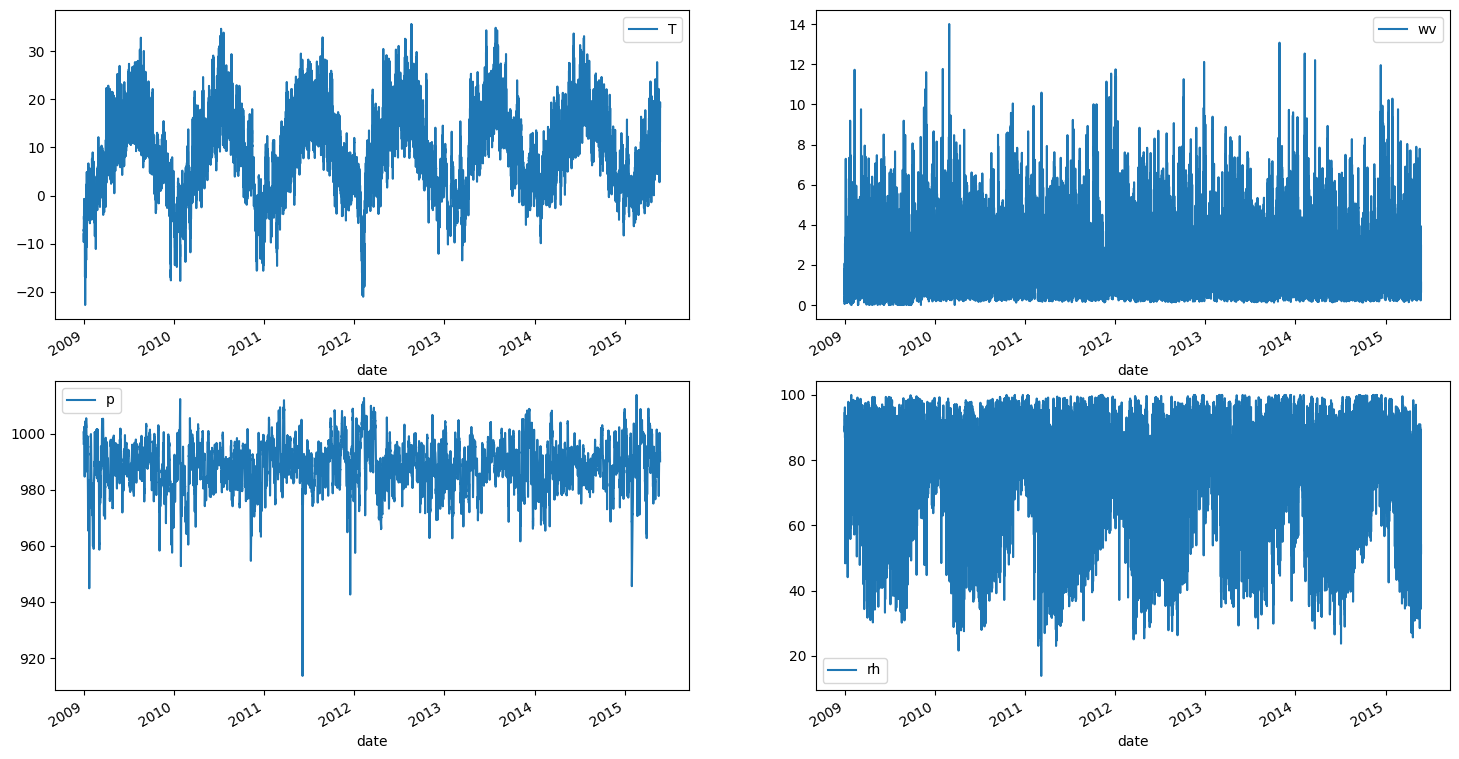

In [ ]:
# create a subplot with 4 rows and 1 column
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

# plot the graphs for each label
data.plot(ax=ax[0][0], x='date', y='T')
data.plot(ax=ax[1][0], x='date', y='p')
data.plot(ax=ax[1][1], x='date', y='rh')
data.plot(ax=ax[0][1], x='date', y='wv')

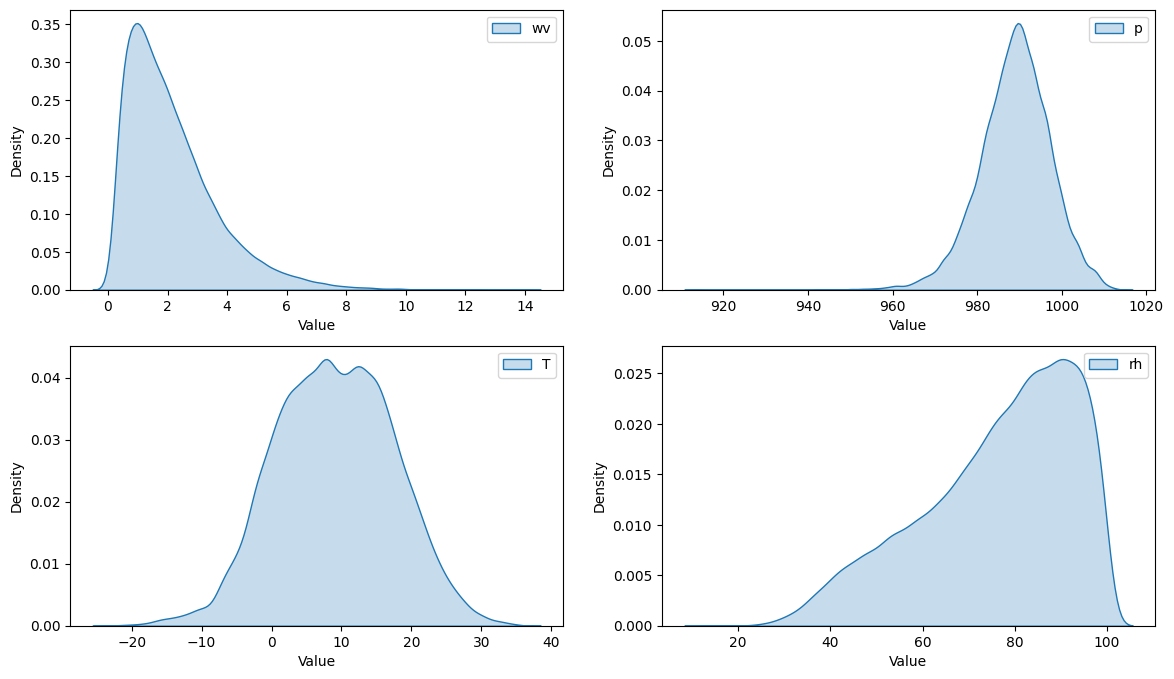

In [ ]:
import seaborn as sns

# Plot kernel density of all labels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(data['wv'], fill=True,  label='wv', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(data['p'], fill=True,  label='p', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(data['T'], fill=True,  label='T', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(data['rh'], fill=True,  label='rh', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

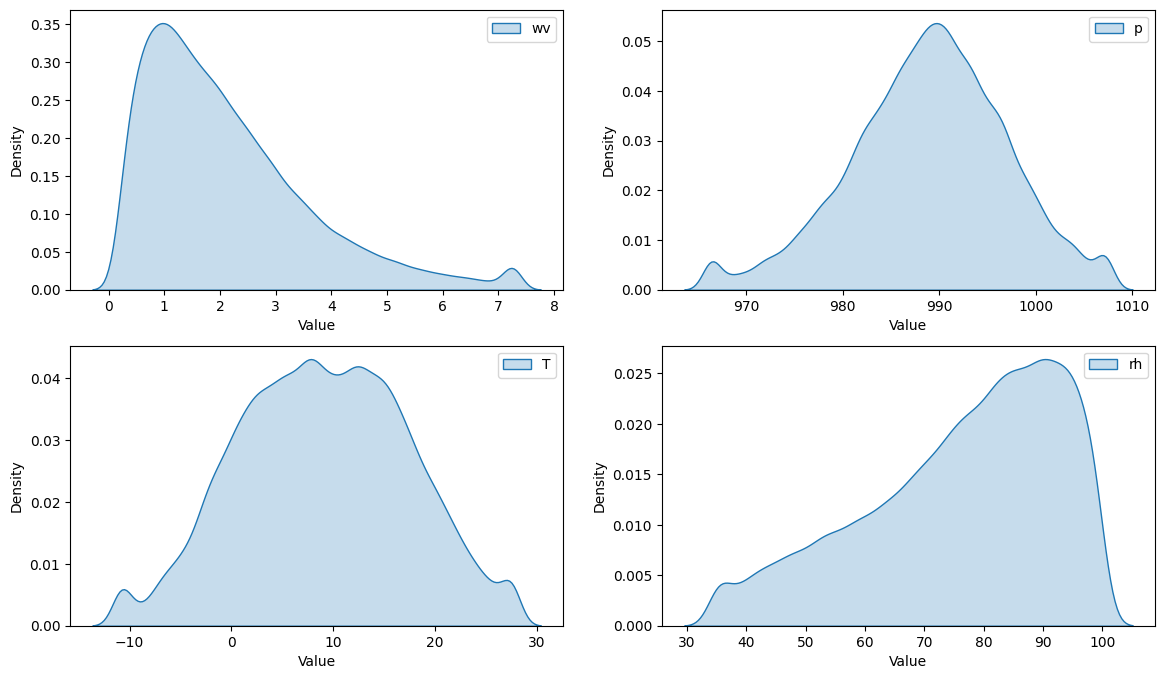

In [ ]:
data['date'] = data['date'].apply(lambda x: x.replace(minute=0))
data.drop("date", inplace=True, axis=1)

# Define the clipping range for outliers
clip_min = data.quantile(0.01)
clip_max = data.quantile(0.99)

# Scale the data with clipping for outliers
df_scaled = data.clip(clip_min, clip_max, axis=1)

# Plot kernel density of all labels
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.kdeplot(df_scaled['wv'], fill=True,  label='wv', ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()

sns.kdeplot(df_scaled['p'], fill=True,  label='p', ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Density')
axes[1].legend()

sns.kdeplot(df_scaled['T'], fill=True,  label='T', ax=axes[2])
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Density')
axes[2].legend()

sns.kdeplot(df_scaled['rh'], fill=True,  label='rh', ax=axes[3])
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Density')
axes[3].legend()

In [ ]:
def custom_date_parser(date_string):
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')

data = pd.read_csv(os.path.join(path, "weather_train.csv"), parse_dates = ['Date Time'], date_parser=custom_date_parser)
data.head()

data.sort_values(by='Date Time', ascending=True, inplace=True)

data = data.rename(columns={'p (mbar)': 'p', 'T (degC)': 'T', 'rh (%)': 'rh', 'wv (m/s)': 'wv', 'Date Time': 'date'})

data['date'] = data['date'].apply(lambda x: x.replace(minute=0))

# create an empty list to store the indices of non-consecutive rows
non_consecutive_rows = []

# iterate through the rows of the dataframe
for i in range(1, len(data)):
    # get the current and previous timestamps
    curr_timestamp = data['date'][i]
    prev_timestamp = data['date'][i-1]
    
    # check if the difference between the timestamps is greater than one hour
    if (curr_timestamp - prev_timestamp) > pd.Timedelta(hours=1):
        # if so, append the index of the current row to the list of non-consecutive rows
        non_consecutive_rows.append(i)

# display the list of non-consecutive rows
print(f"Number of non consecutive rows {len(non_consecutive_rows)}")
print(f"Percentage of non consecutive rows : {len(non_consecutive_rows) / len(data['date']) * 100:.1f}%")



'''remove time stamp but keep all features'''
data = data.drop('date', axis=1)
data.info()

data = np.array(data) # fully data array (56072, 14) PREPROCESSING ENDS HERE (fully data array)

<ipython-input-125-b646cdb61a7e>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(date_string, '%d.%m.%Y %H:%M:%S')


Number of non consecutive rows 1
Percentage of non consecutive rows : 0.0%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56072 entries, 0 to 56071
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p                56072 non-null  float64
 1   T                56072 non-null  float64
 2   Tpot (K)         56072 non-null  float64
 3   Tdew (degC)      56072 non-null  float64
 4   rh               56072 non-null  float64
 5   VPmax (mbar)     56072 non-null  float64
 6   VPact (mbar)     56072 non-null  float64
 7   VPdef (mbar)     56072 non-null  float64
 8   sh (g/kg)        56072 non-null  float64
 9   H2OC (mmol/mol)  56072 non-null  float64
 10  rho (g/m**3)     56072 non-null  float64
 11  wv               56072 non-null  float64
 12  max. wv (m/s)    56072 non-null  float64
 13  wd (deg)         56072 non-null  float64
dtypes: float64(14)
memory usage: 8.4 MB


## Model 1: Fully Connected Baseline (k=4; 3 hidden layers)

In [ ]:
'''MAKE DATA SET (MLP configuration)'''

INPUT_SIZE = 4*14
OUTPUT_SIZE = 4

'''reorganize dataset into samples (build "X" and "y" below)'''
# Total number of time steps: 56072; each sample spans 5 time steps (4 input + 1 output)

X = np.zeros((56072-4, INPUT_SIZE))
y = np.zeros((56072-4, OUTPUT_SIZE))

for i in range(56072-4):
  X[i, :] = data[i:i+4, :].reshape(1, INPUT_SIZE)
  y[i, :] = data[i+4, [0, 1, 4, 11]] # four output features

In [ ]:
'''MAKE DATA SET (MLP configuration)'''

# data loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class WeatherDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.Tensor(X)
    self.y = torch.Tensor(y)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    return self.X[idx, :], self.y[idx, :]

In [ ]:
'''MAKE DATA SET (MLP configuration)'''

BATCH_SIZE = 1000

# from torch.utils.data.dataloader import T
dataset = WeatherDataset(X, y)

# train test split
num_test = len(dataset) // 10  # 10% samples for validation
num_train = len(dataset) - num_test
train, val = random_split(dataset, [num_train, num_test])

# load data
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val, batch_size=num_test, shuffle=True)

In [ ]:
'''
build fully connected model:
1) k = 4
2) three hidden layers
3) 4 nodes in each hidden layer
4) fully connected NN
'''

class FullyConnectModel(nn.Module):
  def __init__(self):
    super(FullyConnectModel, self).__init__()
    self.layer1 = nn.Linear(INPUT_SIZE, 4)
    self.layer2 = nn.Linear(4, 4)
    self.layer3 = nn.Linear(4, 4)
    self.layerout = nn.Linear(4, OUTPUT_SIZE)

  def forward(self, x):
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return self.layerout(x)

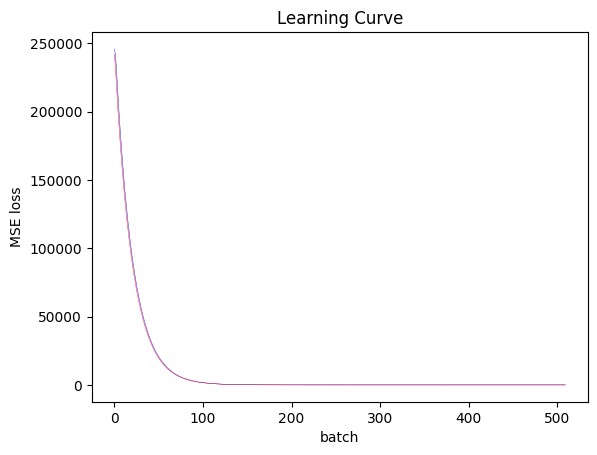

minimum MSE training loss (fully connected): 95.76337432861328

minimum MSE test loss (fully connected): 103.44345092773438



In [ ]:
'''TRAIN fc_model'''

def train_fc_model(train_dataloader, val_dataloader):
  EPOCHES = 10

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  # model trainning
  fc_model = FullyConnectModel()
  fc_model.to(device)
  criterion = F.mse_loss
  optimizer = optim.SGD(fc_model.parameters(), lr=1e-2)

  train_loss = []
  val_loss = []

  for epoch in range(EPOCHES):

    for inputs, labels in train_dataloader:
      inputs = torch.reshape(inputs, (-1, INPUT_SIZE)).to(device)
      labels = labels.to(device)

      # trainning 
      fc_model.train()
      optimizer.zero_grad()
      outputs = fc_model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # validation
      fc_model.eval()
      with torch.no_grad():
        inputs, labels = next(iter(val_dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = fc_model(inputs)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

  # plot learning curve
  plt.figure()
  plt.title("Learning Curve")
  plt.plot(train_loss, linewidth=0.3, c="b")
  plt.plot(val_loss, linewidth=0.3, c="r")
  plt.xlabel("batch")
  plt.ylabel("MSE loss")
  plt.show()

  print("minimum MSE training loss (fully connected): " + str(min(train_loss)) + "\n")
  print("minimum MSE test loss (fully connected): " + str(min(val_loss)) + "\n")

  return fc_model, min(train_loss), min(val_loss)

fc_model, _, _ = train_fc_model(train_dataloader, val_dataloader)

## Model 2: LSTM Baseline Model (k=4; 3 hidden layers)



In [ ]:
'''MAKE DATA SET (MLP configuration)'''

INPUT_SIZE = 4*14
OUTPUT_SIZE = 4

'''reorganize dataset into samples (build "X" and "y" below)'''
# Total number of time steps: 56072; each sample spans 5 time steps (4 input + 1 output)

X = np.zeros((56072-4, INPUT_SIZE))
y = np.zeros((56072-4, OUTPUT_SIZE))

for i in range(56072-4):
  X[i, :] = data[i:i+4, :].reshape(1, INPUT_SIZE)
  y[i, :] = data[i+4, [0, 1, 4, 11]] # four output features

In [ ]:
'''MAKE DATA SET (MLP configuration)'''

BATCH_SIZE = 1000

# from torch.utils.data.dataloader import T
dataset = WeatherDataset(X, y)

# train test split
num_test = len(dataset) // 10  # 10% samples for validation
num_train = len(dataset) - num_test
train, val = random_split(dataset, [num_train, num_test])

# load data
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val, batch_size=num_test, shuffle=True)

In [ ]:
OUTPUT_SIZE = 4

import torch.nn as nn
import torch

'''
build fully connected model:
1) k = 4
2) three LSTM layers
3) 4 nodes in each hidden state
4) LSTM with a fully connected output layer
5) input data fed in sequentially
'''

class LSTM_model(nn.Module):
  def __init__(self, n_layers):
    super().__init__()
    self.lstm = nn.LSTM(14, 4, num_layers=n_layers, batch_first=True)
    self.linear = nn.Linear(4, 4)

  def forward(self, x):
    y, _ = self.lstm(x)
    y = y[:, -1, :]  # last output, all samples in the batch, all features
    return self.linear(torch.sigmoid(y))

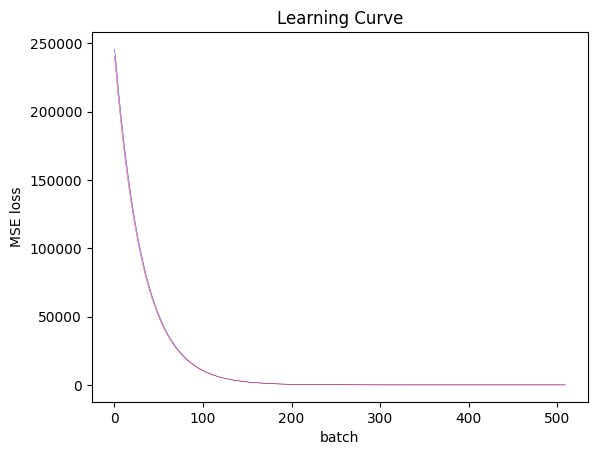

minimum MSE training loss (LSTM): 95.25725555419922

minimum MSE test loss (LSTM): 104.81403350830078



In [ ]:
'''TRAIN lstm_model'''

def train_lstm_model(train_dataloader, val_dataloader):
  EPOCHES = 10

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  n_layers = 3

  # construct model 
  lstm_model = LSTM_model(n_layers)
  optimizer = optim.SGD(lstm_model.parameters(),lr = 1e-2)
  criterion = F.mse_loss
  lstm_model.to(device)

  train_loss = []
  val_loss = []

  for epoch in range(EPOCHES):

    for inputs, labels in train_dataloader:
      # reshape inputs into correct form for LSTM (same dataloader)
      inputs_ = torch.reshape(inputs, (-1, 4, 14))
      inputs_ = inputs_.to(device)
      labels = labels.to(device)

      # trainning 
      lstm_model.train()
      optimizer.zero_grad()
      outputs = lstm_model(inputs_)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

      # validation
      lstm_model.eval()
      with torch.no_grad():
        inputs, labels = next(iter(val_dataloader))
        inputs_ = torch.reshape(inputs, (-1, 4, 14))
        inputs_ = inputs_.to(device)
        labels = labels.to(device)

        outputs = lstm_model(inputs_)
        loss = criterion(outputs, labels)
        val_loss.append(loss.item())

  # plot learning curve
  plt.figure()
  plt.title("Learning Curve")
  plt.plot(train_loss, linewidth=0.3, c="b")
  plt.plot(val_loss, linewidth=0.3, c="r")
  plt.xlabel("batch")
  plt.ylabel("MSE loss")
  plt.show()

  print("minimum MSE training loss (LSTM): " + str(min(train_loss)) + "\n")
  print("minimum MSE test loss (LSTM): " + str(min(val_loss)) + "\n")

  return lstm_model, min(train_loss), min(val_loss)

lstm_model, _, _ = train_lstm_model(train_dataloader, val_dataloader)

## Overall performance (10 fold cross validation)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

'''MAKE DATA SET (MLP configuration)'''

INPUT_SIZE = 14*4
OUTPUT_SIZE = 4

'''reorganize dataset into samples (build "X" and "y" below)'''
# Total number of time steps: 56072; each sample spans 5 time steps (4 input + 1 output)

X = np.zeros((56072-4, INPUT_SIZE))
y = np.zeros((56072-4, OUTPUT_SIZE))

for i in range(56072-4):
  X[i, :] = data[i:i+4, :].reshape(1, INPUT_SIZE)
  y[i, :] = data[i+4, [0, 1, 4, 11]] # four output features

fold 1 starts.


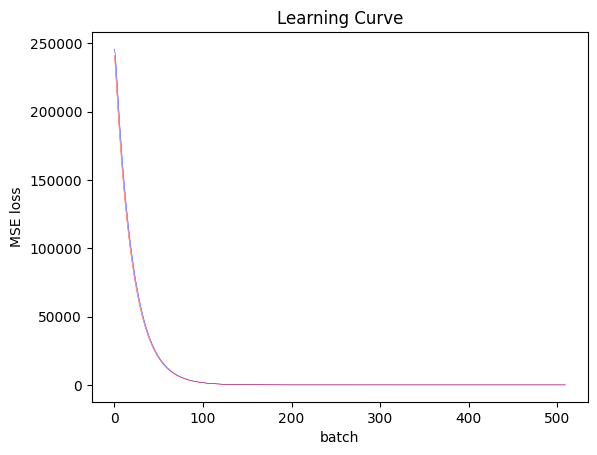

minimum MSE training loss (fully connected): 94.0202407836914

minimum MSE test loss (fully connected): 108.84423065185547



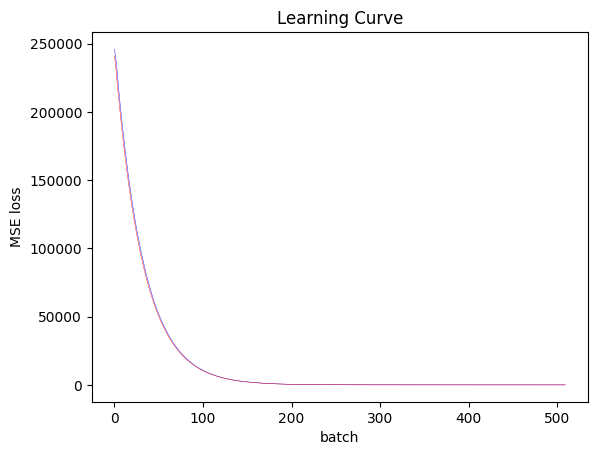

minimum MSE training loss (LSTM): 94.86522674560547

minimum MSE test loss (LSTM): 108.83956146240234

fold 2 starts.


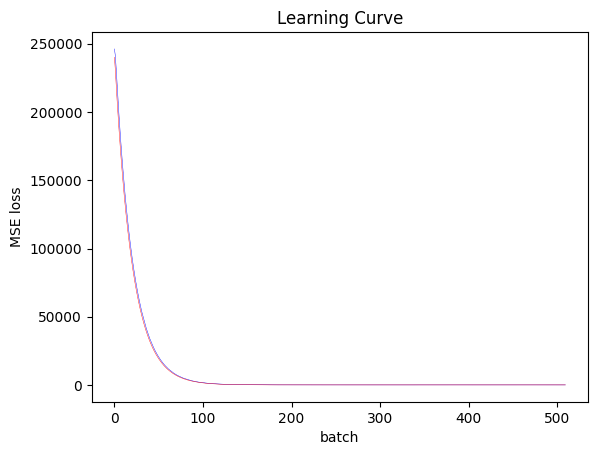

minimum MSE training loss (fully connected): 95.08414459228516

minimum MSE test loss (fully connected): 100.59762573242188



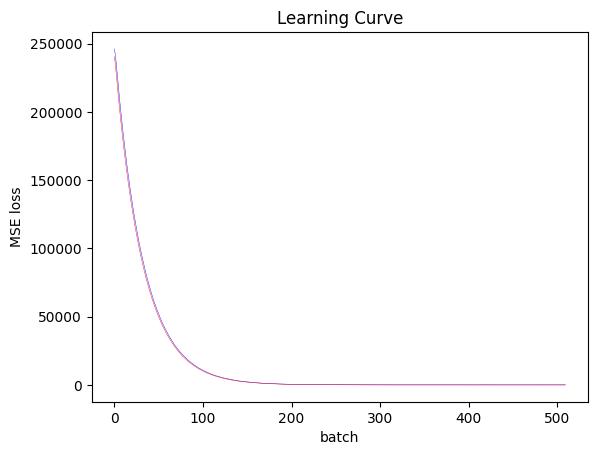

minimum MSE training loss (LSTM): 96.17189025878906

minimum MSE test loss (LSTM): 100.50679779052734

fold 3 starts.


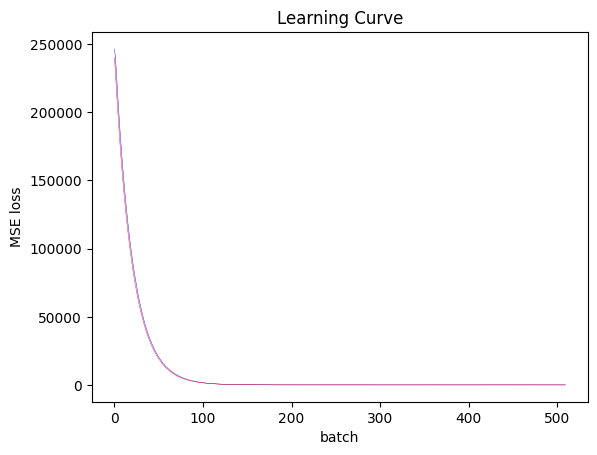

minimum MSE training loss (fully connected): 95.53569793701172

minimum MSE test loss (fully connected): 105.11336517333984



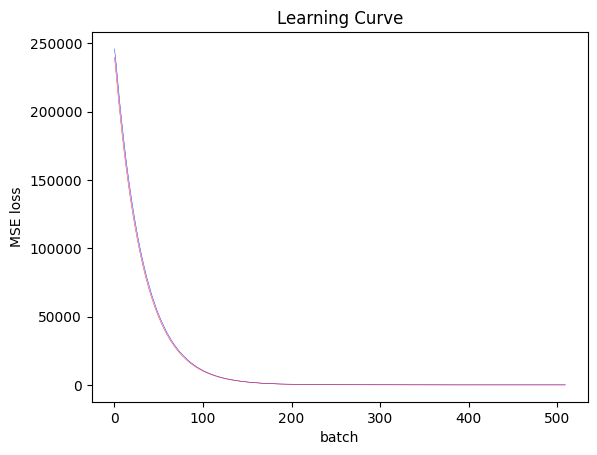

minimum MSE training loss (LSTM): 96.69961547851562

minimum MSE test loss (LSTM): 105.0973129272461

fold 4 starts.


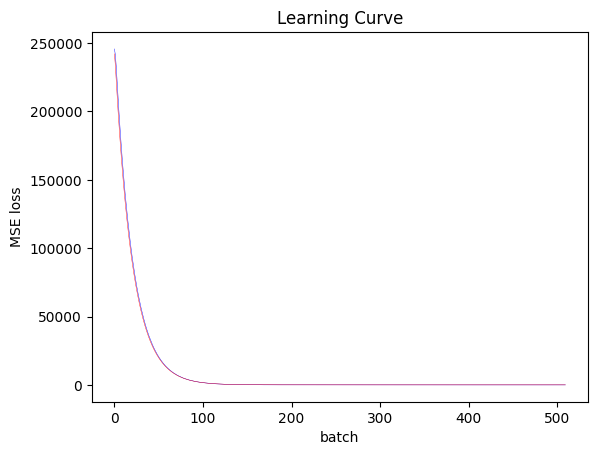

minimum MSE training loss (fully connected): 93.68440246582031

minimum MSE test loss (fully connected): 125.47042846679688



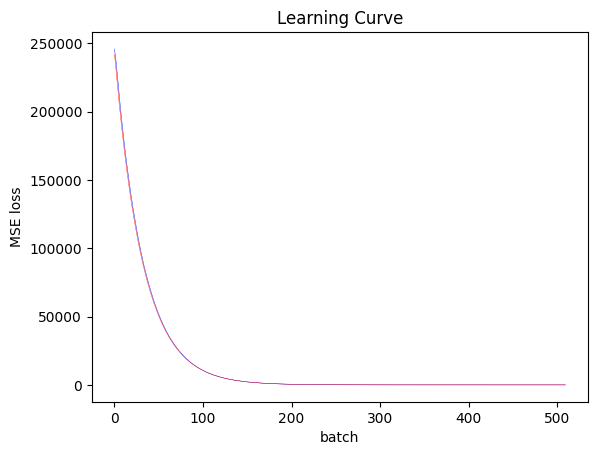

minimum MSE training loss (LSTM): 95.45063018798828

minimum MSE test loss (LSTM): 125.7802963256836

fold 5 starts.


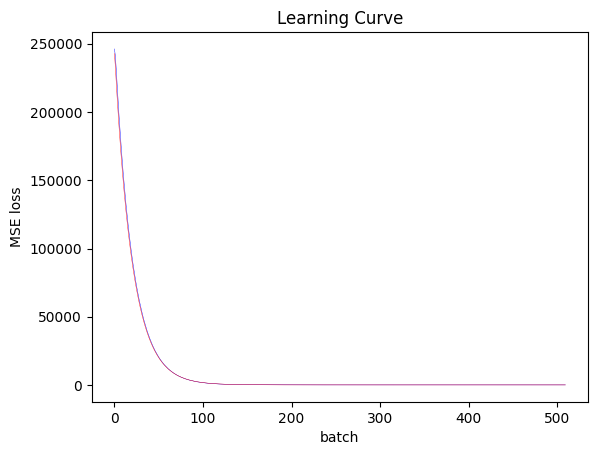

minimum MSE training loss (fully connected): 96.3676986694336

minimum MSE test loss (fully connected): 91.31280517578125



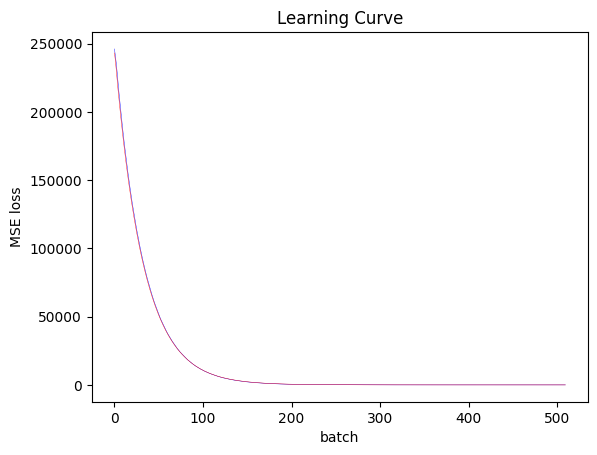

minimum MSE training loss (LSTM): 97.3348617553711

minimum MSE test loss (LSTM): 92.06382751464844

fold 6 starts.


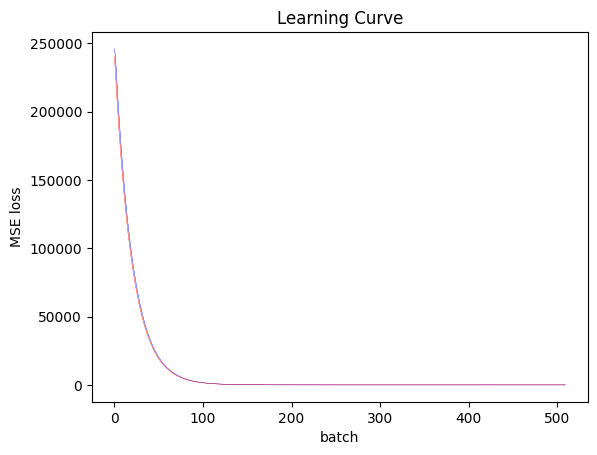

minimum MSE training loss (fully connected): 91.73786163330078

minimum MSE test loss (fully connected): 123.80708312988281



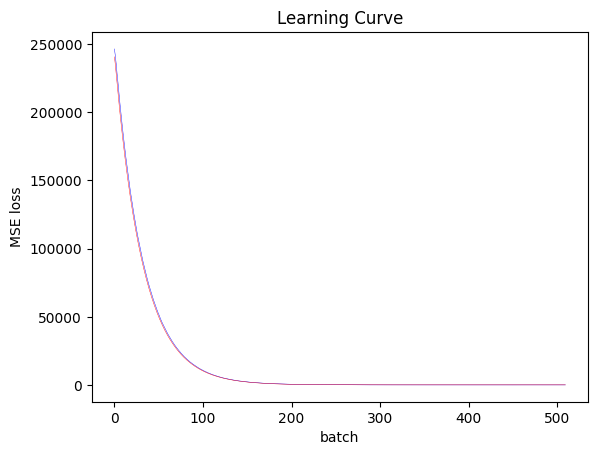

minimum MSE training loss (LSTM): 94.7968978881836

minimum MSE test loss (LSTM): 123.75751495361328

fold 7 starts.


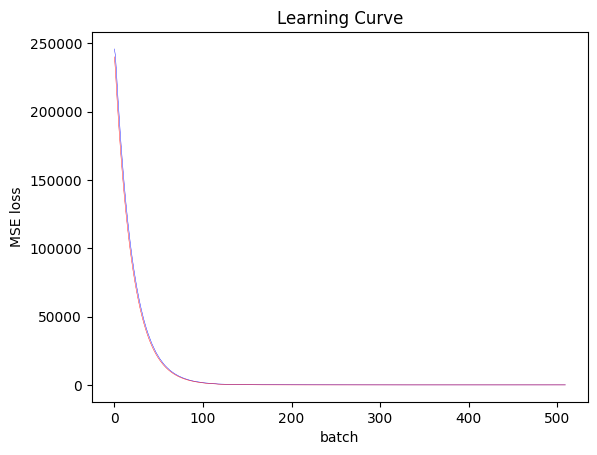

minimum MSE training loss (fully connected): 98.78580474853516

minimum MSE test loss (fully connected): 93.41751861572266



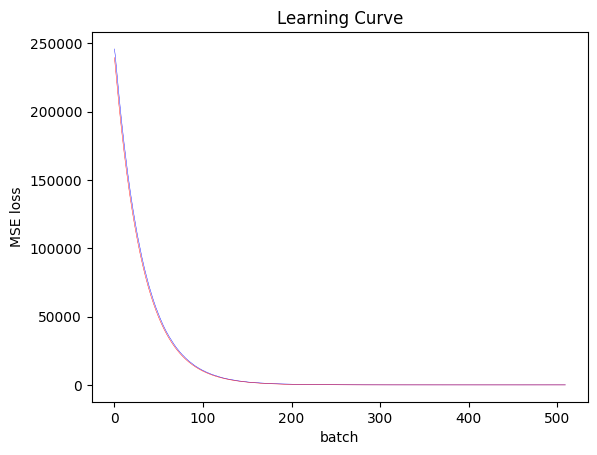

minimum MSE training loss (LSTM): 97.02149963378906

minimum MSE test loss (LSTM): 93.34748077392578

fold 8 starts.


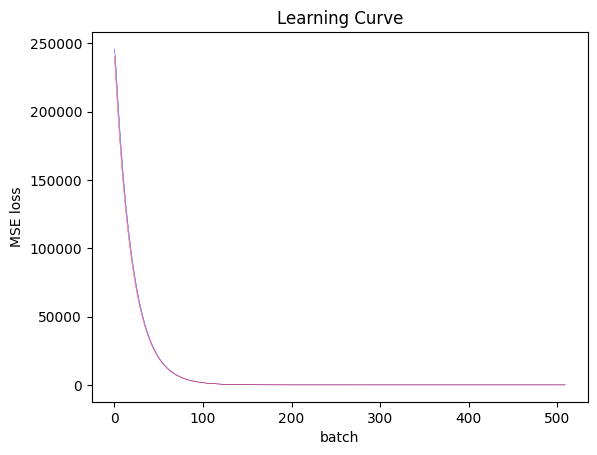

minimum MSE training loss (fully connected): 96.93218231201172

minimum MSE test loss (fully connected): 96.92230224609375



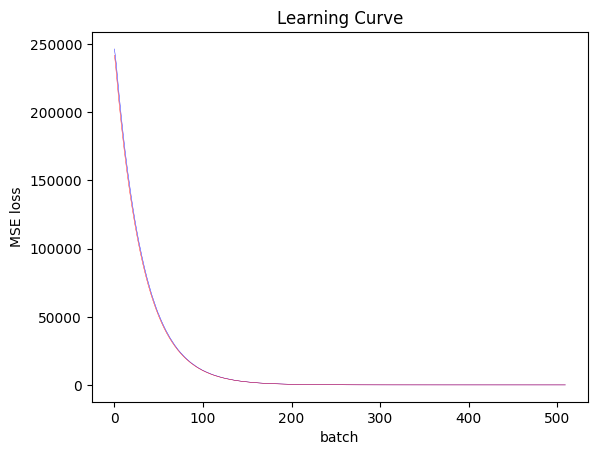

minimum MSE training loss (LSTM): 97.73016357421875

minimum MSE test loss (LSTM): 97.11414337158203

fold 9 starts.


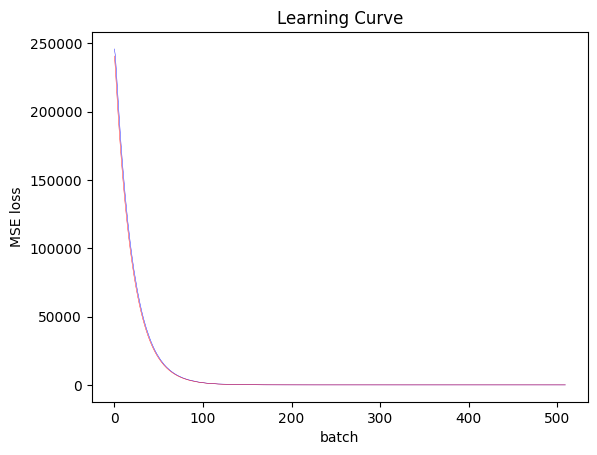

minimum MSE training loss (fully connected): 95.928955078125

minimum MSE test loss (fully connected): 104.20682525634766



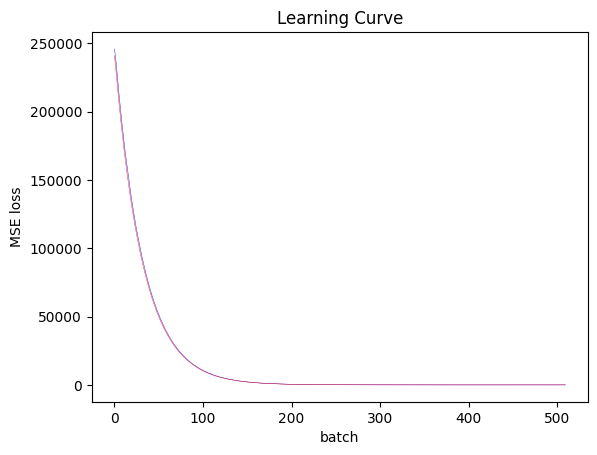

minimum MSE training loss (LSTM): 90.25463104248047

minimum MSE test loss (LSTM): 104.39498901367188

fold 10 starts.


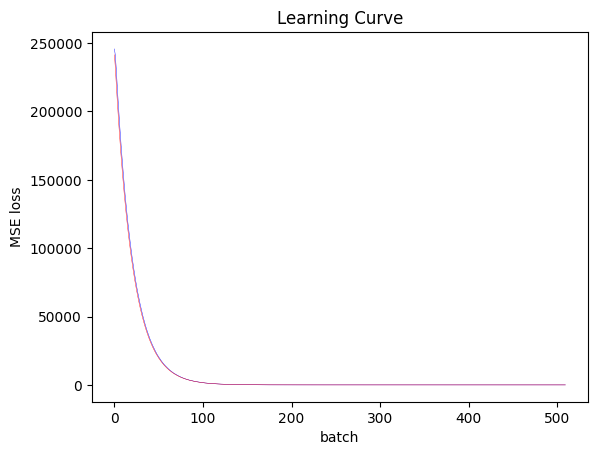

minimum MSE training loss (fully connected): 96.5850601196289

minimum MSE test loss (fully connected): 98.82807159423828



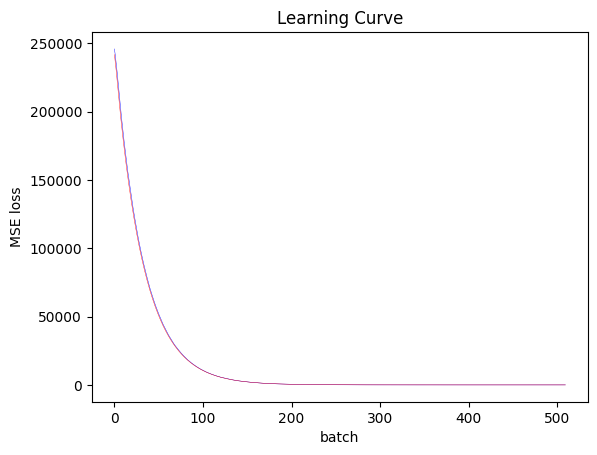

minimum MSE training loss (LSTM): 97.43492889404297

minimum MSE test loss (LSTM): 99.14414978027344

fc:

[108.84423065185547, 100.59762573242188, 105.11336517333984, 125.47042846679688, 91.31280517578125, 123.80708312988281, 93.41751861572266, 96.92230224609375, 104.20682525634766, 98.82807159423828]
lstm:

[108.83956146240234, 100.50679779052734, 105.0973129272461, 125.7802963256836, 92.06382751464844, 123.75751495361328, 93.34748077392578, 97.11414337158203, 104.39498901367188, 99.14414978027344]


In [ ]:
'''MAKE DATA SET (MLP configuration)'''
BATCH_SIZE = 1000
kf = KFold(n_splits=10)

mse_list_fc = []
mse_list_lstm = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
  print("fold " + str(fold+1) + " starts.")

  # prepare this fold
  X_train = X[train_index, :]
  y_train = y[train_index, :]
  X_val = X[val_index, :]
  y_val = y[val_index, :]

  # prepare data 
  dataset_train  = WeatherDataset(X_train, y_train)
  dataset_val  = WeatherDataset(X_val, y_val)

  train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
  val_dataloader = DataLoader(dataset_val, batch_size=len(dataset_val), shuffle=True)

  # train models and record performances
  _, _, v_mse = train_fc_model(train_dataloader, val_dataloader)
  mse_list_fc.append(v_mse)

  _, _, v_mse = train_lstm_model(train_dataloader, val_dataloader)
  mse_list_lstm.append(v_mse)

# performance
print("fc:\n")
print(mse_list_fc)

print("lstm:\n")
print(mse_list_lstm)

In [ ]:
# mean and standard deviation
print("fc MSE mean:\n")
print(str(np.mean(mse_list_fc)) + "\n")

print("fc MSE std:\n")
print(str(np.std(mse_list_fc)) + "\n")

print("lstm MSE mean:\n")
print(str(np.mean(mse_list_lstm)) + "\n")

print("lstm MSE std:\n")
print(str(np.std(mse_list_lstm)) + "\n")

<class 'numpy.float64'>
fc MSE mean:

104.85202560424804

fc MSE std:

11.100278906433589

lstm MSE mean:

105.00460739135742

lstm MSE std:

11.038908262144801



## Performances on individual features 

*First train models with sections one and two*

In [ ]:
def mse(v1, v2):
  return np.mean((v1-v2)**2)

In [ ]:
# fc_model 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = F.mse_loss
optimizer = optim.SGD(fc_model.parameters(), lr=1e-2)


with torch.no_grad():
  inputs, labels = next(iter(val_dataloader))
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = fc_model(inputs)

outputs = outputs.cpu().numpy()
labels = labels.cpu().numpy()

# feature 1:
print("feature 1: ")
print(mse(outputs[:, 0], labels[:, 0]))
print("\n")

# feature 2:
print("feature 2: ")
print(mse(outputs[:, 1], labels[:, 1]))
print("\n")

# feature 3:
print("feature 3: ")
print(mse(outputs[:, 2], labels[:, 2]))
print("\n")

# feature 4:
print("feature 4: ")
print(mse(outputs[:, 3], labels[:, 3]))
print("\n")

feature 1: 
68.27878


feature 2: 
72.701805


feature 3: 
275.79855


feature 4: 
2.3446074




In [ ]:
# LSTM model 

with torch.no_grad():
  inputs, labels = next(iter(val_dataloader))
  inputs_ = torch.reshape(inputs, (-1, 4, 14))
  inputs_ = inputs_.to(device)
  labels = labels.to(device)
  outputs = lstm_model(inputs_)

outputs = outputs.cpu().numpy()
labels = labels.cpu().numpy()

# feature 1:
print("feature 1: ")
print(mse(outputs[:, 0], labels[:, 0]))
print("\n")

# feature 2:
print("feature 2: ")
print(mse(outputs[:, 1], labels[:, 1]))
print("\n")

# feature 3:
print("feature 3: ")
print(mse(outputs[:, 2], labels[:, 2]))
print("\n")

# feature 4:
print("feature 4: ")
print(mse(outputs[:, 3], labels[:, 3]))
print("\n")

feature 1: 
68.420525


feature 2: 
72.70144


feature 3: 
275.7896


feature 4: 
2.344593




## Error propagation (predict up to time "t+4")

In [ ]:
'''first, train both models with 56 input features (only use first 56000 to make sure test time steps are unseen by the model)'''

INPUT_SIZE = 56
OUTPUT_SIZE = 4

'''reorganize dataset into samples (build "X" and "y" below)'''
# Total number of time steps: 56072; each sample spans 5 time steps (4 input + 1 output)

X = np.zeros((56072-4, 56))
y = np.zeros((56072-4, OUTPUT_SIZE))

for i in range(56072-4):
  X[i, :] = data[i:i+4, :].reshape(1, 56)
  y[i, :] = data[i+4, [0, 1, 4, 11]] 

# data loader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

'''MAKE DATA SET (MLP configuration)'''

BATCH_SIZE = 1000

# train models with first 56000 samples
dataset = WeatherDataset(X[:56000, :], y[:56000])
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

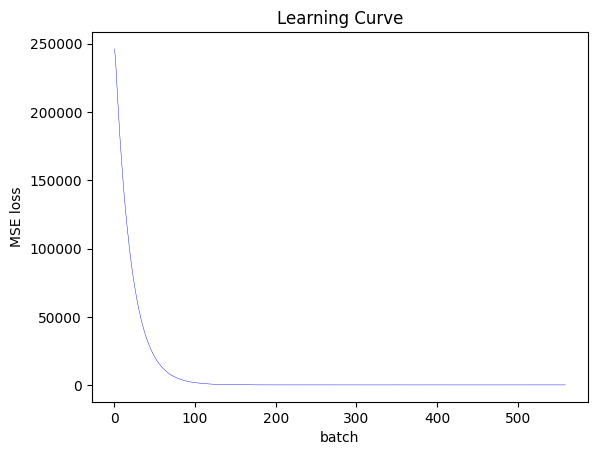

minimum MSE training loss (fully connected): 94.95437622070312



In [ ]:
# train both models with four input features
INPUT_SIZE = 56

class FC(nn.Module):
  def __init__(self):
    super(FC, self).__init__()
    self.layer1 = nn.Linear(56, 4)
    self.layer2 = nn.Linear(4, 4)
    self.layer3 = nn.Linear(4, 4)
    self.layerout = nn.Linear(4, 4)

  def forward(self, x):
    x = torch.sigmoid(self.layer1(x))
    x = torch.sigmoid(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return self.layerout(x)

EPOCHES = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model trainning
fc_model = FC()
fc_model.to(device)
criterion = F.mse_loss
optimizer = optim.SGD(fc_model.parameters(), lr=1e-2)

train_loss = []

for epoch in range(EPOCHES):

  for inputs, labels in train_dataloader:
    inputs = torch.reshape(inputs, (-1, INPUT_SIZE)).to(device)
    labels = labels.to(device)

    # trainning 
    fc_model.train()
    optimizer.zero_grad()
    outputs = fc_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

# plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.plot(train_loss, linewidth=0.3, c="b")
plt.xlabel("batch")
plt.ylabel("MSE loss")
plt.show()

print("minimum MSE training loss (fully connected): " + str(min(train_loss)) + "\n")

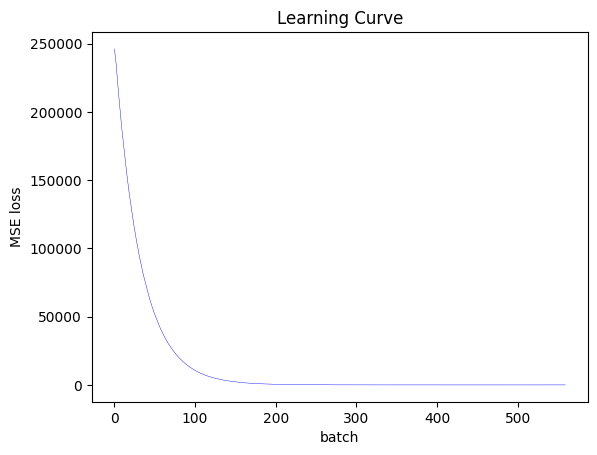

minimum MSE training loss (LSTM): 95.19025421142578



In [ ]:
OUTPUT_SIZE = 4

import torch.nn as nn
import torch

'''
build fully connected model:
1) k = 4
2) three LSTM layers
3) 4 nodes in each hidden state
4) LSTM with a fully connected output layer
5) input data fed in sequentially
'''

class LS(nn.Module):
  def __init__(self, n_layers):
    super().__init__()
    self.lstm = nn.LSTM(14, 4, num_layers=n_layers, batch_first=True)
    self.linear = nn.Linear(4, 4)

  def forward(self, x):
    y, _ = self.lstm(x)
    y = y[:, -1, :]  # last output, all samples in the batch, all features
    return self.linear(torch.sigmoid(y))


EPOCHES = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_layers = 3

# construct model 
lstm_model = LS(n_layers)
optimizer = optim.SGD(lstm_model.parameters(),lr = 1e-2)
criterion = F.mse_loss
lstm_model.to(device)

train_loss = []

for epoch in range(EPOCHES):

  for inputs, labels in train_dataloader:
    # reshape inputs into correct form for LSTM (same dataloader)
    inputs_ = torch.reshape(inputs, (-1, 4, 14))
    inputs_ = inputs_.to(device)
    labels = labels.to(device)

    # trainning 
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(inputs_)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

# plot learning curve
plt.figure()
plt.title("Learning Curve")
plt.plot(train_loss, linewidth=0.3, c="b")
plt.xlabel("batch")
plt.ylabel("MSE loss")
plt.show()

print("minimum MSE training loss (LSTM): " + str(min(train_loss)) + "\n")

*t = 56010, k = 4*

In [ ]:
'''now, both models are trained: fc_model ; lstm_model for input size 56'''

# go back to original data array (56072, 14), slice out relevant portion
input_data = data[56010-4:56010+5, :]  # (9, 14)

# ground truth value from t to t+K (5 steps in total)
feature_1_gt = input_data[4:, 0]
feature_2_gt = input_data[4:, 1]
feature_3_gt = input_data[4:, 4]
feature_4_gt = input_data[4:, 11]

# fc predictions
feature_1_fc = []
feature_2_fc = []
feature_3_fc = []
feature_4_fc = []

# lstm predictions 
feature_1_lstm = []
feature_2_lstm = []
feature_3_lstm = []
feature_4_lstm = []

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = F.mse_loss
optimizer = optim.SGD(fc_model.parameters(), lr=1e-2)


In [ ]:
'''fc'''

# STEP 1
input = input_data[:4, :]
input = torch.tensor(input)
input = torch.reshape(input, (-1, 56))

with torch.no_grad():
  input = input.to(device)

  # fc model
  outputs = fc_model(input.float())
  outputs = outputs.cpu().numpy().flatten()

  feature_1_fc.append(outputs[0])
  feature_2_fc.append(outputs[1])
  feature_3_fc.append(outputs[2])
  feature_4_fc.append(outputs[3])

# Step 2-5  
for i in range(1, 5):
  input = input_data[i:4+i, :]
  input[-1, 0] = feature_1_fc[-1]
  input[-1, 1] = feature_2_fc[-1]
  input[-1, 4] = feature_3_fc[-1]
  input[-1, 11] = feature_4_fc[-1]

  input = torch.tensor(input)
  input = torch.reshape(input, (-1, 56))

  with torch.no_grad():
    input = input.to(device)

    # fc model
    outputs = fc_model(input.float())
    outputs = outputs.cpu().numpy().flatten()

    feature_1_fc.append(outputs[0])
    feature_2_fc.append(outputs[1])
    feature_3_fc.append(outputs[2])
    feature_4_fc.append(outputs[3])

In [ ]:
'''LSTM'''  

# STEP 1
input = input_data[:4, :]
input = torch.tensor(input)
input = torch.reshape(input, (-1, 4, 14))

with torch.no_grad():
  input = input.to(device)

  # lstm model
  outputs = lstm_model(input.float())
  outputs = outputs.cpu().numpy().flatten()

  feature_1_lstm.append(outputs[0])
  feature_2_lstm.append(outputs[1])
  feature_3_lstm.append(outputs[2])
  feature_4_lstm.append(outputs[3])

# Step 2-5  
for i in range(1, 5):
  input = input_data[i:4+i, :]
  input[-1, 0] = feature_1_lstm[-1]
  input[-1, 1] = feature_2_lstm[-1]
  input[-1, 4] = feature_3_lstm[-1]
  input[-1, 11] = feature_4_lstm[-1]

  input = torch.tensor(input)
  input = torch.reshape(input, (-1, 4, 14))

  with torch.no_grad():
    input = input.to(device)

    # lstm model
    outputs = lstm_model(input.float())
    outputs = outputs.cpu().numpy().flatten()

    feature_1_lstm.append(outputs[0])
    feature_2_lstm.append(outputs[1])
    feature_3_lstm.append(outputs[2])
    feature_4_lstm.append(outputs[3])

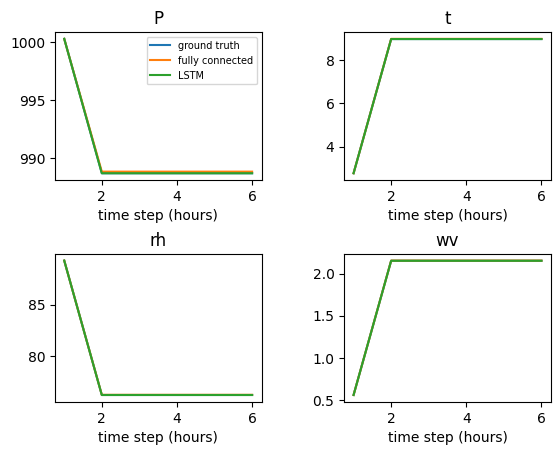

In [ ]:
feature_1_gt = np.insert(feature_1_gt, 0, input_data[3, 0])
feature_2_gt = np.insert(feature_2_gt, 0, input_data[3, 1])
feature_3_gt = np.insert(feature_3_gt, 0, input_data[3, 4])
feature_4_gt = np.insert(feature_4_gt, 0, input_data[3, 11])

feature_1_fc = np.insert(feature_1_fc, 0, input_data[3, 0])
feature_2_fc = np.insert(feature_2_fc, 0, input_data[3, 1])
feature_3_fc = np.insert(feature_3_fc, 0, input_data[3, 4])
feature_4_fc = np.insert(feature_4_fc, 0, input_data[3, 11])

feature_1_lstm = np.insert(feature_1_lstm, 0, input_data[3, 0])
feature_2_lstm = np.insert(feature_2_lstm, 0, input_data[3, 1])
feature_3_lstm = np.insert(feature_3_lstm, 0, input_data[3, 4])
feature_4_lstm = np.insert(feature_4_lstm, 0, input_data[3, 11])

'''ploting'''

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(wspace=0.4, hspace=0.5)

axs[0, 0].plot([i+1 for i in range(6)], feature_1_gt, label='ground truth')
axs[0, 0].plot([i+1 for i in range(6)], feature_1_fc, label='fully connected')
axs[0, 0].plot([i+1 for i in range(6)], feature_1_lstm, label='LSTM')
axs[0, 0].legend(fontsize="7")
axs[0, 0].set_title('P')

axs[0, 1].plot([i+1 for i in range(6)], feature_2_gt, label='ground truth')
axs[0, 1].plot([i+1 for i in range(6)], feature_2_fc, label='fully connected')
axs[0, 1].plot([i+1 for i in range(6)], feature_2_lstm, label='LSTM')
axs[0, 0].legend(fontsize="7")
axs[0, 1].set_title('t')

axs[1, 0].plot([i+1 for i in range(6)], feature_3_gt, label='ground truth')
axs[1, 0].plot([i+1 for i in range(6)], feature_3_fc, label='fully connected')
axs[1, 0].plot([i+1 for i in range(6)], feature_3_lstm, label='LSTM')
axs[0, 0].legend(fontsize="7")
axs[1, 0].set_title('rh')

axs[1, 1].plot([i+1 for i in range(6)], feature_4_gt, label='ground truth')
axs[1, 1].plot([i+1 for i in range(6)], feature_4_fc, label='fully connected')
axs[1, 1].plot([i+1 for i in range(6)], feature_4_lstm, label='LSTM')
axs[0, 0].legend(fontsize="7")
axs[1, 1].set_title('wv')

for ax in axs.flat:
    ax.set(xlabel='time step (hours)', ylabel='')
